In [1]:
import scipy as sci
import scipy.special as sp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
import cartopy.crs as ccrs
import os, glob

In [2]:
def sh_visualize(folder="shinr",dtype="all", title="",L=5,M=3,draw_target=False, show=False,error_max=None):
    print(title)
    print()

    lat, lon = np.linspace(-0.5*np.pi,0.5*np.pi,180), np.linspace(0,2*np.pi,360)

    if dtype == "all":
        start, step = 0, 1
    elif dtype == "train":
        start, step = 0, 2
    else:
        start, step = 1, 2

    lat_idx = np.arange(start, len(lat), step)
    lon_idx = np.arange(start, len(lon), step)

    lat = lat[lat_idx]  # 171
    lon = lon[lon_idx]  # 342



    fontsize= 10

    #As R has negative values, we'll use an instance of Normalize
    #see http://stackoverflow.com/questions/25023075/normalizing-colormap-used-by-facecolors-in-matplotlib
    norm = colors.Normalize()
    
    PHI, THETA = np.meshgrid(lon,lat)
    target = np.load(folder + "/target.npy") - 0.5
    # R = sp.sph_harm(M, L, PHI, THETA).real
    X = target * np.sin(THETA) * np.cos(PHI)
    Y = target * np.sin(THETA) * np.sin(PHI)
    Z = target * np.cos(THETA)

    if draw_target:
        fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(7,5))
        m = cm.ScalarMappable(cmap=cm.jet)
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=cm.jet(norm(target)))
        ax.set_title(f'target real$(Y^{L}_{M})$ {title}', fontsize=fontsize)
        m.set_array(target)
        # fig.colorbar(m, shrink=0.8)
        if show:
            plt.show()

    pred = np.load(folder + '/pred.npy')-0.5
    X = pred * np.sin(THETA) * np.cos(PHI)
    Y = pred * np.sin(THETA) * np.sin(PHI)
    Z = pred * np.cos(THETA)
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(7,5))
    ax.set_title(f'pred real$(Y^{L}_{M})$ {title}', fontsize=fontsize)
    m = cm.ScalarMappable(cmap=cm.jet)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=cm.jet(norm(pred)))
    m.set_array(pred)
    if show:
        plt.show()

    error = target-pred
    # error = error**2
    X = error * np.sin(THETA) * np.cos(PHI)
    Y = error * np.sin(THETA) * np.sin(PHI)
    Z = error * np.cos(THETA)

    fig, ax1 = plt.subplots(figsize=(7,5),subplot_kw=dict(projection='3d'))
    m = cm.ScalarMappable(cmap=cm.jet)
    ax1.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=cm.jet(norm(error)))
    _error_max = np.abs(error).max()
    if error_max is not None:
        ax1.set_xlim(-error_max,error_max)
        ax1.set_ylim(-error_max,error_max)
        ax1.set_zlim(-error_max,error_max)
    ax1.set_title(f'error  $(Y^{L}_ {M})$ {title}', fontsize=fontsize)
    m.set_array(error)
    if show:
        plt.show()
    
    viewpoint = 60
    plotcrs = ccrs.Orthographic(0, 90-viewpoint)
    
    if draw_target:
        fig, ax1 = plt.subplots(figsize=(7,5),subplot_kw=dict(projection=plotcrs))
        # fig, ax1 = plt.subplots(figsize=(7,5))
        vlim = np.max(np.abs(target))
        im = ax1.pcolormesh(PHI*180/np.pi,THETA*180/np.pi,target,transform=ccrs.PlateCarree(),
                            cmap='seismic',vmin=-vlim,vmax=vlim)
        ax1.relim()
        fig.colorbar(im, ax=ax1)    
        ax1.autoscale_view()
        ax1.set_title(f'target  $(Y^{L}_ {M})$ {title}', fontsize=fontsize)
        if show:
            plt.show()
    
    
    """Color map sphere"""
    fig, ax1 = plt.subplots(figsize=(7,5),subplot_kw=dict(projection=plotcrs))
    # fig, ax1 = plt.subplots(figsize=(7,5))
    vlim = np.max(np.abs(pred))
    im = ax1.pcolormesh(PHI*180/np.pi,THETA*180/np.pi,pred,transform=ccrs.PlateCarree(),
                        cmap='seismic',vmin=-vlim,vmax=vlim)
    ax1.relim()
    fig.colorbar(im, ax=ax1)
    ax1.autoscale_view()
    ax1.set_title(f'pred  $(Y^{L}_ {M})$ {title}', fontsize=fontsize)
    if show:
        plt.show()
    
    fig, ax1 = plt.subplots(figsize=(7,5),subplot_kw=dict(projection=plotcrs))
    # fig, ax1 = plt.subplots(figsize=(7,5))
    vlim = np.max(np.abs(error))
    im = ax1.pcolormesh(PHI*180/np.pi,THETA*180/np.pi,error,transform=ccrs.PlateCarree(),
                        cmap='seismic',vmin=-vlim,vmax=vlim)
    ax1.relim()
    fig.colorbar(im, ax=ax1)
    ax1.autoscale_view()
    ax1.set_title(f'error  $(Y^{L}_ {M})$ {title}', fontsize=fontsize)
    if show:
        plt.show()

    """Error hist"""    
    fig, (ax2, ax3) = plt.subplots(1,2,figsize=(7,5))
    counts, bins = np.histogram(error)
    ax2.hist(bins[:-1], bins, weights=counts)
    ax2.set_title(f'error hist $(Y^{L}_{M})$ {title}', fontsize=fontsize)
    ax3.hist(bins[:-1], bins, weights=np.log(counts))
    ax3.set_title(f'error log hist $(Y^{L}_{M})$ {title}', fontsize=fontsize)
    if show:
        plt.show()
        
    
    return PHI, THETA, target, pred, error, _error_max

In [3]:
def sh_visualize_gt(L=30,M=29):
    lat, lon = np.linspace(-0.5*np.pi,0.5*np.pi,180), np.linspace(0,2*np.pi,360)
    PHI, THETA = np.meshgrid(lon,lat)
    R = sp.sph_harm(M, L, PHI, THETA).real
    X = R * np.sin(THETA) * np.cos(PHI)
    Y = R * np.sin(THETA) * np.sin(PHI)
    Z = R * np.cos(THETA)

    #As R has negative values, we'll use an instance of Normalize
    #see http://stackoverflow.com/questions/25023075/normalizing-colormap-used-by-facecolors-in-matplotlib
    norm = colors.Normalize()
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(7,5))
    m = cm.ScalarMappable(cmap=cm.jet)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=cm.jet(norm(R)))
    # ax.set_title('real$(Y^2_ 4)$', fontsize=20)
    m.set_array(R)
    # fig.colorbar(m, shrink=0.8)
    plt.show()
    
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([0,2*np.pi,-0.5*np.pi,0.5*np.pi], crs=ccrs.PlateCarree())
    # Create a contour plot of the spherical harmonics on the Plate Carrée map
    contour = ax.contourf(PHI, THETA, R, cmap='coolwarm', levels=50, transform=ccrs.PlateCarree())
    # plt.colorbar(contour, ax=ax, label='Spherical Harmonics Value')

    # Set title and show the map
    ax.set_title(f'Spherical Harmonics (Degree {L}, Order {M}) on Plate Carrée Projection')
    plt.show()
    
    viewpoint = 60
    plotcrs = ccrs.Orthographic(0, 90-viewpoint)
    
    fig, ax1 = plt.subplots(figsize=(7,5),subplot_kw=dict(projection=plotcrs))
    # fig, ax1 = plt.subplots(figsize=(7,5))
    vlim = np.max(np.abs(R))
    im = ax1.pcolormesh(PHI*180/np.pi,THETA*180/np.pi,R,transform=ccrs.PlateCarree(),
                        cmap='seismic',vmin=-vlim,vmax=vlim)
    ax1.relim()
    fig.colorbar(im, ax=ax1)    
    ax1.autoscale_view()
    
    return PHI, THETA, R
# a = sh_visualize_gt(5,3)
# a = sh_visualize_gt(30,29)

['../../harmonics_output/l40_m39/9pycyp0o_all', '../../harmonics_output/l40_m39/n8c6ctnt_all', '../../harmonics_output/l40_m39/0oizj0hz_all', '../../harmonics_output/l40_m39/fqzpw584_all', '../../harmonics_output/l40_m39/k8r9sh9e_all', '../../harmonics_output/l40_m39/s0kdalkv_all', '../../harmonics_output/l40_m39/nqsnchqn_all', '../../harmonics_output/l40_m39/wdbbz3cu_all', '../../harmonics_output/l40_m39/fcz36jwb_all', '../../harmonics_output/l40_m39/w49harnu_all', '../../harmonics_output/l40_m39/c3rtax3m_all', '../../harmonics_output/l40_m39/6wzqgmwp_all']
swinr



/tmp/ipykernel_3993826/2534087297.py:123: RuntimeWarning: divide by zero encountered in log
  ax3.hist(bins[:-1], bins, weights=np.log(counts))
/home/guest_sky/.conda/envs/hm_sinr3/lib/python3.8/site-packages/numpy/lib/function_base.py:1448: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


swinr

swinr

swinr

swinr



/tmp/ipykernel_3993826/2534087297.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(7,5))
/tmp/ipykernel_3993826/2534087297.py:123: RuntimeWarning: divide by zero encountered in log
  ax3.hist(bins[:-1], bins, weights=np.log(counts))
/home/guest_sky/.conda/envs/hm_sinr3/lib/python3.8/site-packages/numpy/lib/function_base.py:1448: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


swinr

swinr



/tmp/ipykernel_3993826/2534087297.py:123: RuntimeWarning: divide by zero encountered in log
  ax3.hist(bins[:-1], bins, weights=np.log(counts))
/home/guest_sky/.conda/envs/hm_sinr3/lib/python3.8/site-packages/numpy/lib/function_base.py:1448: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


swinr



ValueError: operands could not be broadcast together with shapes (90,180) (180,360) 

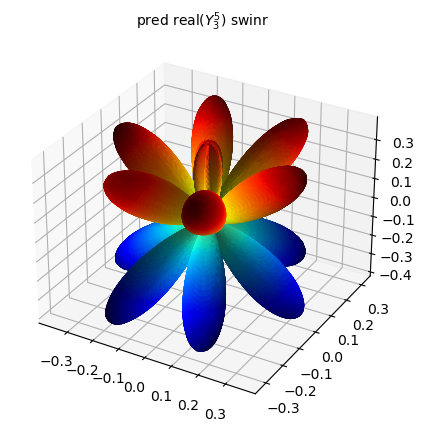

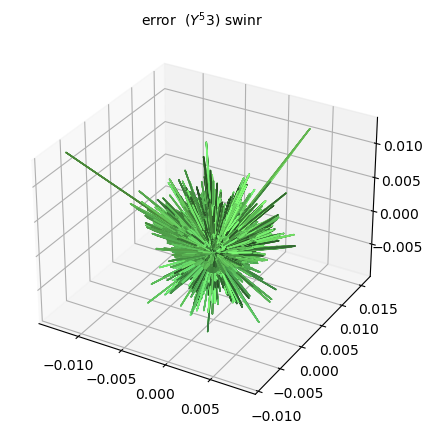

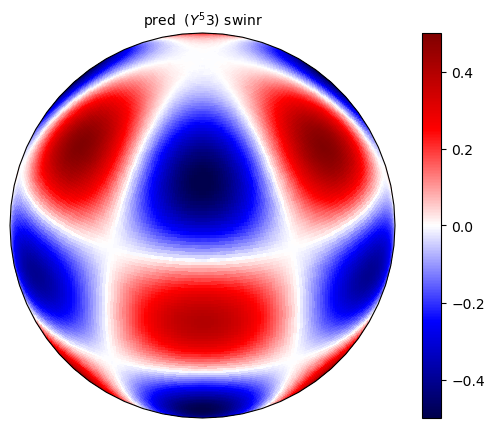

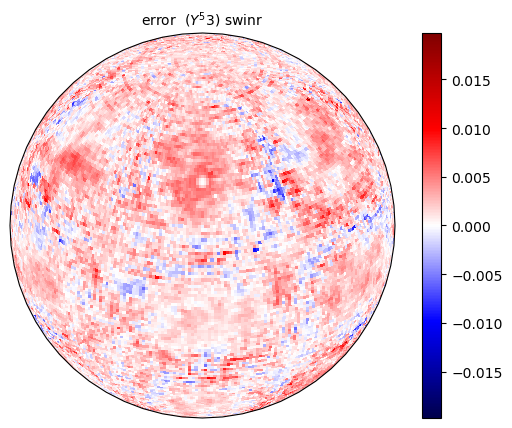

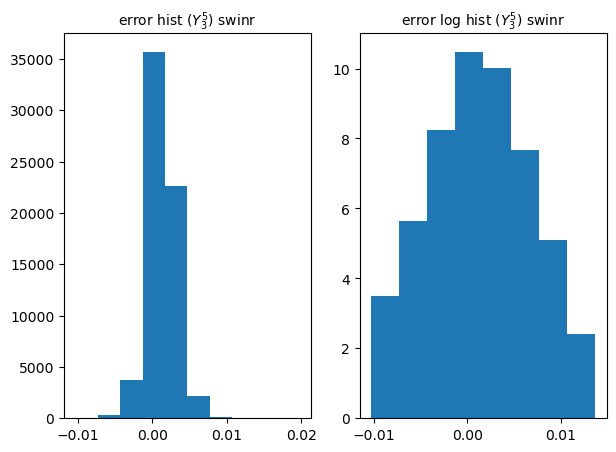

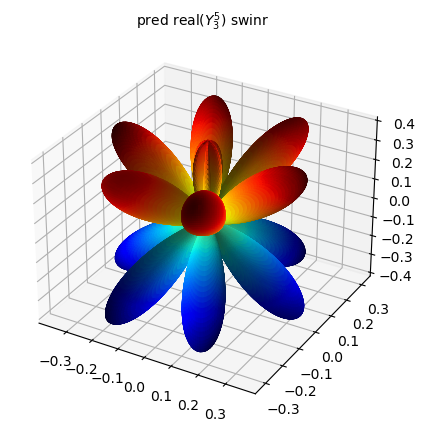

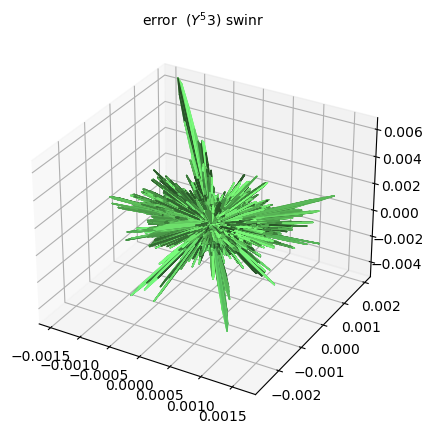

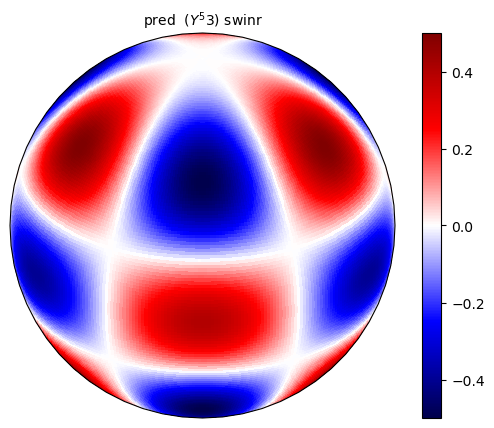

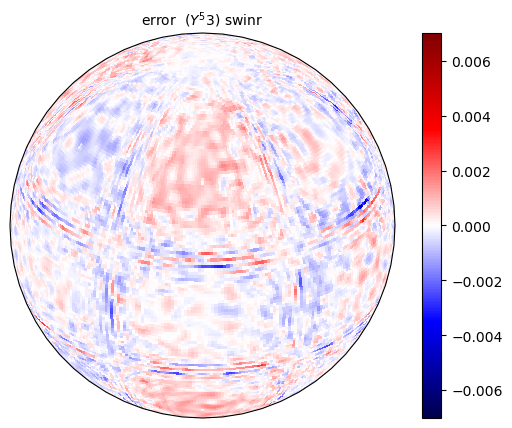

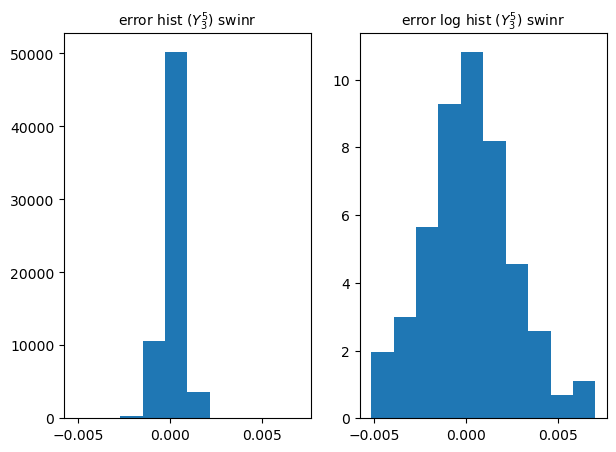

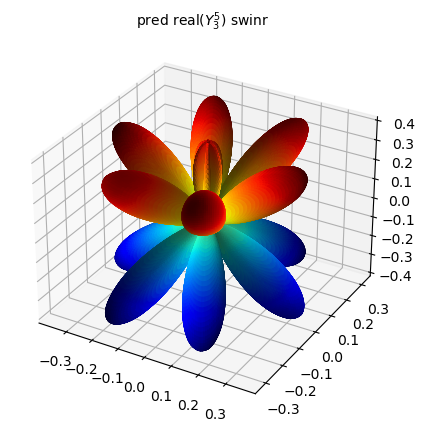

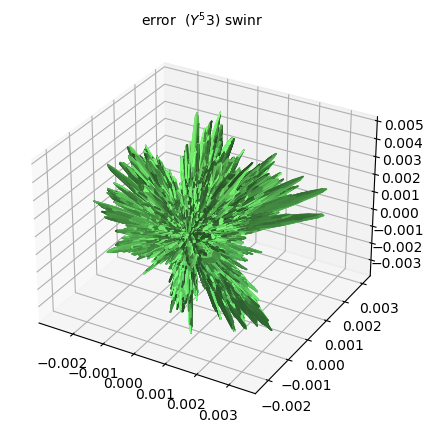

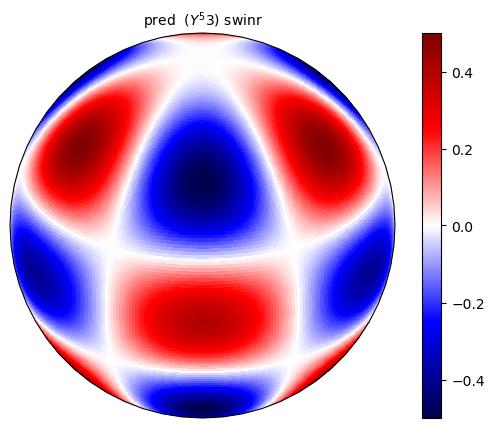

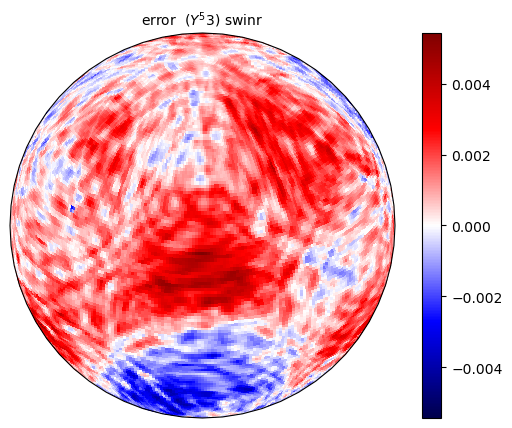

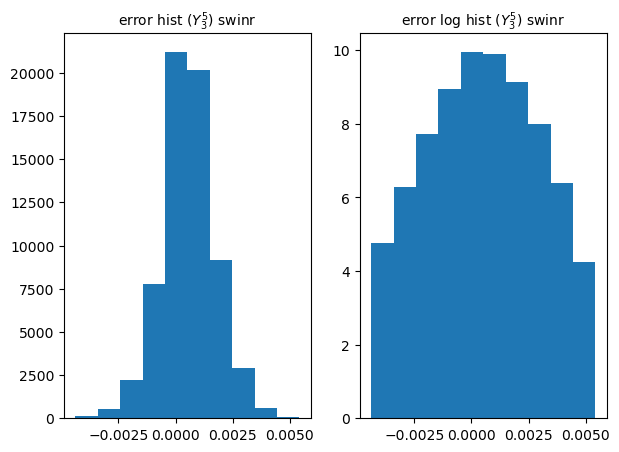

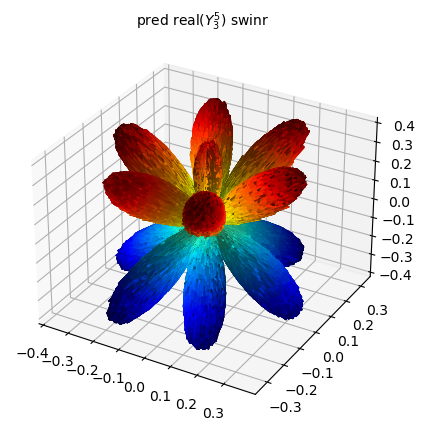

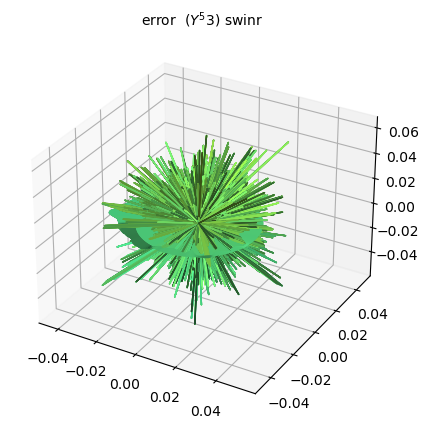

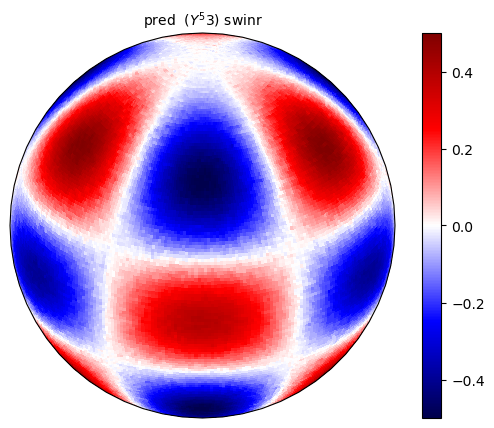

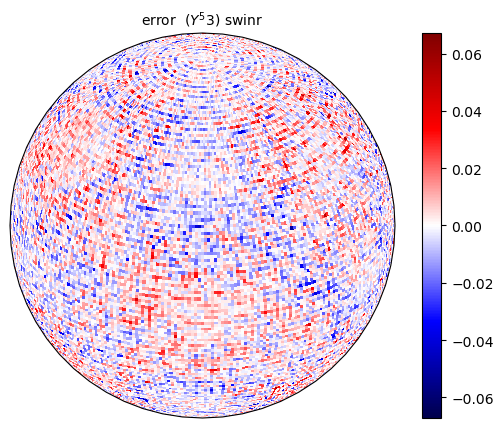

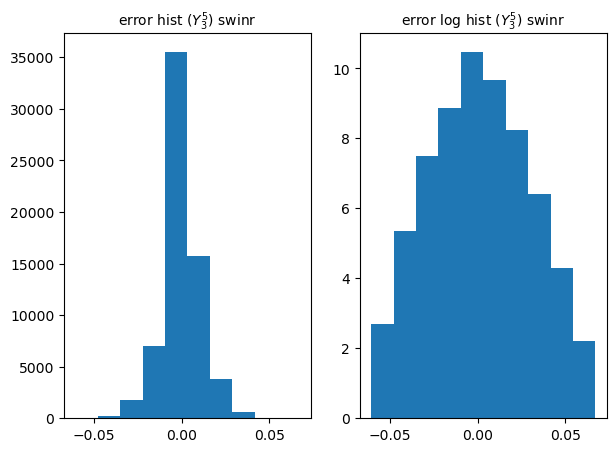

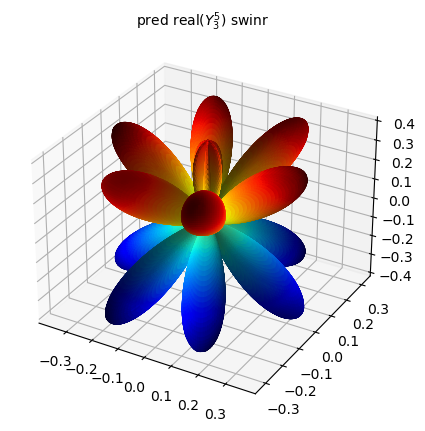

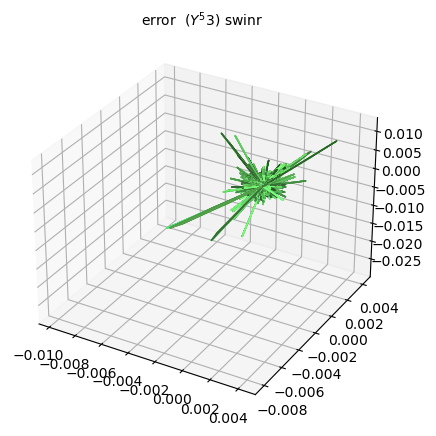

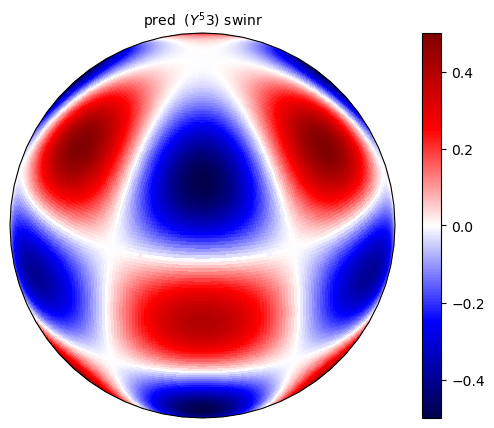

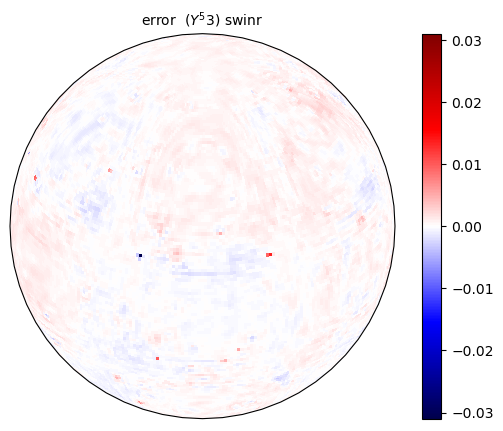

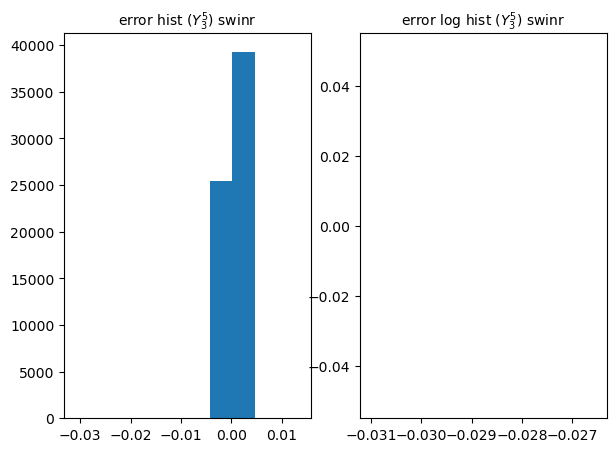

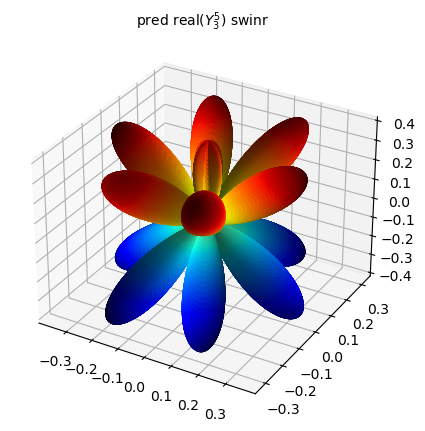

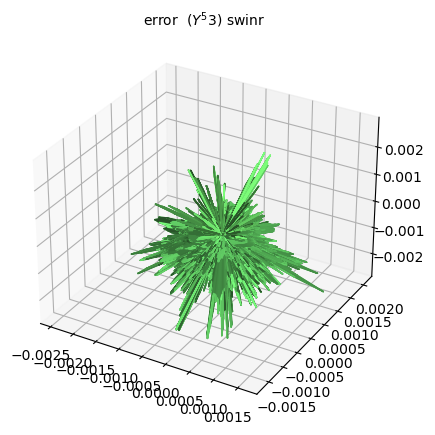

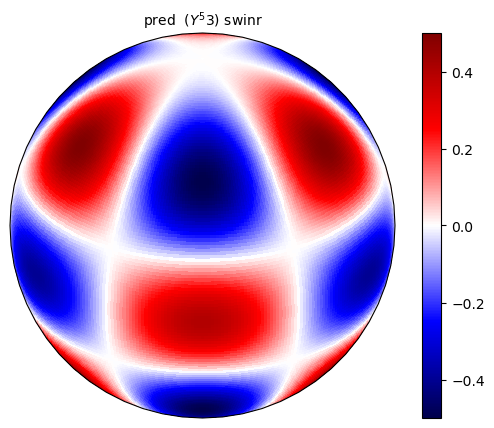

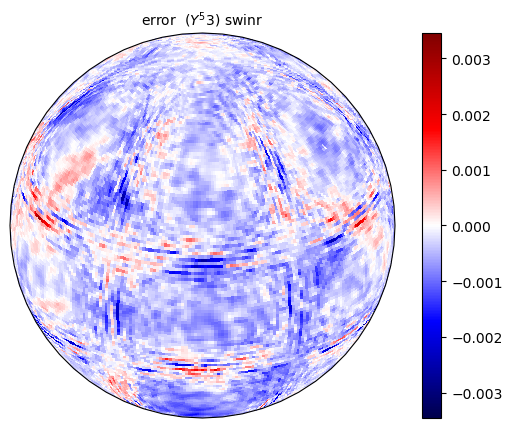

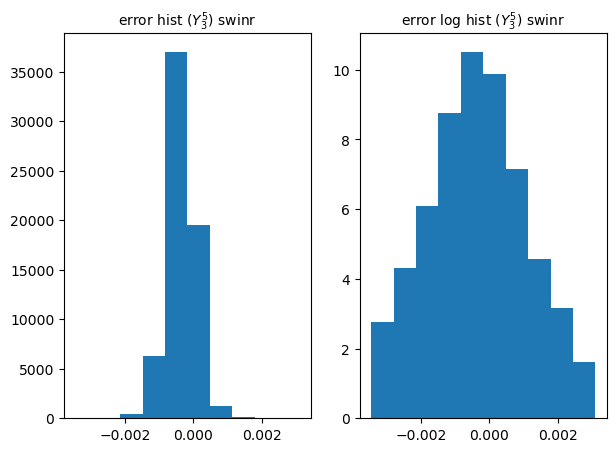

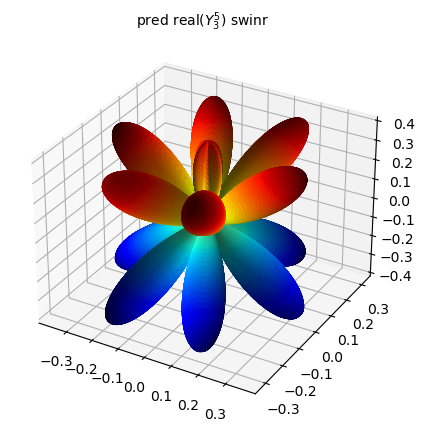

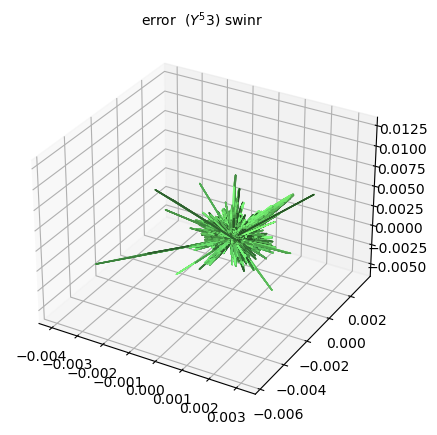

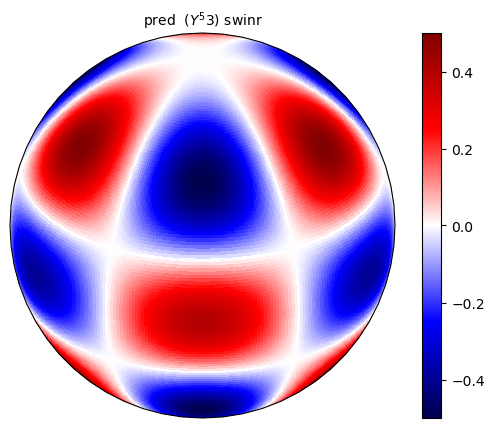

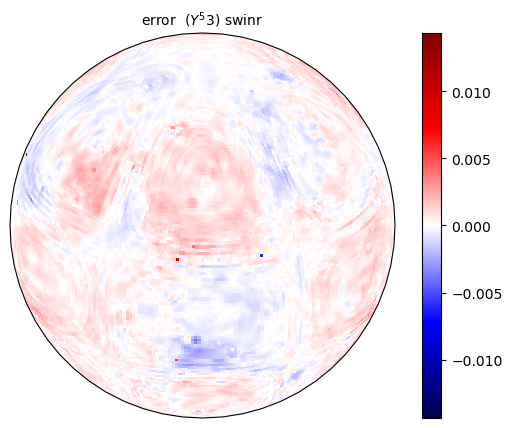

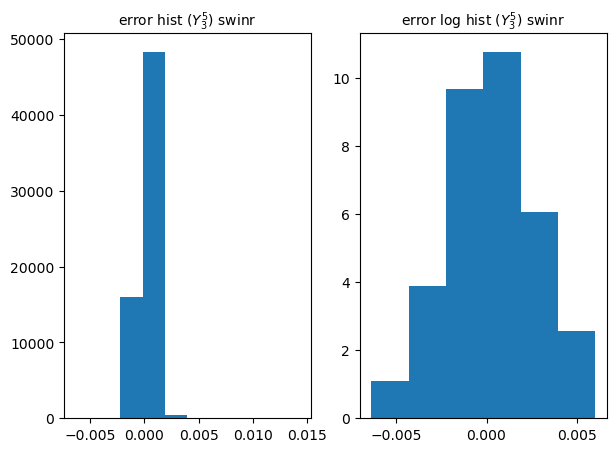

In [4]:
files = glob.glob(os.path.join("../../harmonics_output/l40_m39", "*"))
files = [file for file in files if "all" in file]
print(files)
for file in files:
    k = sh_visualize(file,title="swinr")
    # em.append(k[-1])